In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/img-caption/flickr_annotations_30k.csv
/kaggle/input/img-caption/flickr30k-images/flickr30k-images/flickr30k-images/2715746315.jpg
/kaggle/input/img-caption/flickr30k-images/flickr30k-images/flickr30k-images/3463034205.jpg
/kaggle/input/img-caption/flickr30k-images/flickr30k-images/flickr30k-images/268704620.jpg
/kaggle/input/img-caption/flickr30k-images/flickr30k-images/flickr30k-images/2673564214.jpg
/kaggle/input/img-caption/flickr30k-images/flickr30k-images/flickr30k-images/7535037918.jpg
/kaggle/input/img-caption/flickr30k-images/flickr30k-images/flickr30k-images/4912369161.jpg
/kaggle/input/img-caption/flickr30k-images/flickr30k-images/flickr30k-images/4828071602.jpg
/kaggle/input/img-caption/flickr30k-images/flickr30k-images/flickr30k-images/6802728196.jpg
/kaggle/input/img-caption/flickr30k-images/flickr30k-images/flickr30k-images/3346289227.jpg
/kaggle/input/img-caption/flickr30k-images/flickr30k-images/flickr30k-images/3217056901.jpg
/kaggle/input/img-caption/fl

In [2]:
!pip install einops

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 1.9 MB/s eta 0:00:00


In [3]:
import pandas as pd
import os
import json
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import nltk
from collections import Counter
from nltk.tokenize import word_tokenize
import torch.nn.functional as F
import torch.optim as optim
from torch import nn, einsum
import numpy as np
from einops import rearrange
from einops.layers.torch import Rearrange
# from google.colab import drive
# drive.mount('/content/drive')

# Load the annotations
df = pd.read_csv('/kaggle/input/img-caption/flickr_annotations_30k.csv')

# Filter out rows where image is not present or captions are missing
image_dir = '/kaggle/input/img-caption/flickr30k-images/flickr30k-images/flickr30k-images'
df['image_exists'] = df['filename'].apply(lambda x: os.path.exists(os.path.join(image_dir, x)))
df = df[df['image_exists']]

# Parse the captions from JSON strings
df['captions'] = df['raw'].apply(lambda x: json.loads(x))
df = df[df['captions'].apply(lambda x: len(x) > 0)]

# Separate data into train, validation, and test sets
train_df = df[df['split'] == 'train']
val_df = df[df['split'] == 'val']
test_df = df[df['split'] == 'test']


In [4]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229]),  # Ensure mean and std are lists
])



# Create a custom Dataset
class Flickr30kDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        self.dataframe = dataframe
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
         row = self.dataframe.iloc[idx]
         image_path = os.path.join(self.image_dir, row['filename'])

         # Load image and convert to grayscale
         image = Image.open(image_path).convert('L')  # Convert image to grayscale

         # Conditionally convert grayscale image to RGB if transform expects RGB input
         if self.transform is not None:
             if self.transform.transforms[-1].mean[0] == 0.485:
                 image = transforms.Grayscale(num_output_channels=3)(image)

             image = self.transform(image)

         captions = row['captions']
         return image, captions
# Create DataLoaders
train_dataset = Flickr30kDataset(train_df, image_dir, transform=transform)
val_dataset = Flickr30kDataset(val_df, image_dir, transform=transform)
test_dataset = Flickr30kDataset(test_df, image_dir, transform=transform)

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0, pin_memory=True, collate_fn=lambda batch: (
    torch.stack([item[0] for item in batch]),  # Stack images into a single tensor
    [item[1] for item in batch]  # Captions as a list of lists
))

val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=0, pin_memory=True, collate_fn=lambda batch: (
    torch.stack([item[0] for item in batch]),  # Stack images into a single tensor
    [item[1] for item in batch]  # Captions as a list of lists
))

test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=0, pin_memory=True, collate_fn=lambda batch: (
    torch.stack([item[0] for item in batch]),  # Stack images into a single tensor
    [item[1] for item in batch]  # Captions as a list of lists
))



In [5]:
class CyclicShift(nn.Module):
    def __init__(self, displacement):
        super().__init__()
        self.displacement = displacement

    def forward(self, x):
        return torch.roll(x, shifts=(self.displacement, self.displacement), dims=(1, 2))


class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(x, **kwargs) + x


class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)


class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, dim),
        )

    def forward(self, x):
        return self.net(x)


def create_mask(window_size, displacement, upper_lower, left_right):
    mask = torch.zeros(window_size ** 2, window_size ** 2)

    if upper_lower:
        mask[-displacement * window_size:, :-displacement * window_size] = float('-inf')
        mask[:-displacement * window_size, -displacement * window_size:] = float('-inf')

    if left_right:
        mask = rearrange(mask, '(h1 w1) (h2 w2) -> h1 w1 h2 w2', h1=window_size, h2=window_size)
        mask[:, -displacement:, :, :-displacement] = float('-inf')
        mask[:, :-displacement, :, -displacement:] = float('-inf')
        mask = rearrange(mask, 'h1 w1 h2 w2 -> (h1 w1) (h2 w2)')

    return mask


def get_relative_distances(window_size):
    indices = torch.tensor(np.array([[x, y] for x in range(window_size) for y in range(window_size)]))
    distances = indices[None, :, :] - indices[:, None, :]
    return distances


class WindowAttention(nn.Module):
    def __init__(self, dim, heads, head_dim, shifted, window_size, relative_pos_embedding):
        super().__init__()
        inner_dim = head_dim * heads

        self.heads = heads
        self.scale = head_dim ** -0.5
        self.window_size = window_size
        self.relative_pos_embedding = relative_pos_embedding
        self.shifted = shifted

        if self.shifted:
            displacement = window_size // 2
            self.cyclic_shift = CyclicShift(-displacement)
            self.cyclic_back_shift = CyclicShift(displacement)
            self.upper_lower_mask = nn.Parameter(create_mask(window_size=window_size, displacement=displacement,
                                                             upper_lower=True, left_right=False), requires_grad=False)
            self.left_right_mask = nn.Parameter(create_mask(window_size=window_size, displacement=displacement,
                                                            upper_lower=False, left_right=True), requires_grad=False)

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias=False)

        if self.relative_pos_embedding:
            self.relative_indices = get_relative_distances(window_size) + window_size - 1
            self.pos_embedding = nn.Parameter(torch.randn(2 * window_size - 1, 2 * window_size - 1))
        else:
            self.pos_embedding = nn.Parameter(torch.randn(window_size ** 2, window_size ** 2))

        self.to_out = nn.Linear(inner_dim, dim)

    def forward(self, x):
        if self.shifted:
            x = self.cyclic_shift(x)

        b, n_h, n_w, _, h = *x.shape, self.heads

        qkv = self.to_qkv(x).chunk(3, dim=-1)
        nw_h = n_h // self.window_size
        nw_w = n_w // self.window_size

        q, k, v = map(
            lambda t: rearrange(t, 'b (nw_h w_h) (nw_w w_w) (h d) -> b h (nw_h nw_w) (w_h w_w) d',
                                h=h, w_h=self.window_size, w_w=self.window_size), qkv)

        dots = einsum('b h w i d, b h w j d -> b h w i j', q, k) * self.scale

        if self.relative_pos_embedding:
            dots += self.pos_embedding[self.relative_indices[:, :, 0], self.relative_indices[:, :, 1]]
        else:
            dots += self.pos_embedding

        if self.shifted:
            dots[:, :, -nw_w:] += self.upper_lower_mask
            dots[:, :, nw_w - 1::nw_w] += self.left_right_mask

        attn = dots.softmax(dim=-1)

        out = einsum('b h w i j, b h w j d -> b h w i d', attn, v)
        out = rearrange(out, 'b h (nw_h nw_w) (w_h w_w) d -> b (nw_h w_h) (nw_w w_w) (h d)',
                        h=h, w_h=self.window_size, w_w=self.window_size, nw_h=nw_h, nw_w=nw_w)
        out = self.to_out(out)

        if self.shifted:
            out = self.cyclic_back_shift(out)
        return out


class SwinBlock(nn.Module):
    def __init__(self, dim, heads, head_dim, mlp_dim, shifted, window_size, relative_pos_embedding):
        super().__init__()
        self.attention_block = Residual(PreNorm(dim, WindowAttention(dim=dim,
                                                                     heads=heads,
                                                                     head_dim=head_dim,
                                                                     shifted=shifted,
                                                                     window_size=window_size,
                                                                     relative_pos_embedding=relative_pos_embedding)))
        self.mlp_block = Residual(PreNorm(dim, FeedForward(dim=dim, hidden_dim=mlp_dim)))

    def forward(self, x):
        x = self.attention_block(x)
        x = self.mlp_block(x)
        return x


class PatchMerging(nn.Module):
    def __init__(self, in_channels, out_channels, downscaling_factor):
        super().__init__()
        self.downscaling_factor = downscaling_factor
        self.patch_merge = nn.Unfold(kernel_size=downscaling_factor, stride=downscaling_factor, padding=0)
        self.linear = nn.Linear(in_channels * downscaling_factor ** 2, out_channels)

    def forward(self, x):
        b, c, h, w = x.shape
        new_h, new_w = h // self.downscaling_factor, w // self.downscaling_factor
        x = self.patch_merge(x).view(b, -1, new_h, new_w).permute(0, 2, 3, 1)
        x = self.linear(x)
        return x


class StageModule(nn.Module):
    def __init__(self, in_channels, hidden_dimension, layers, downscaling_factor, num_heads, head_dim, window_size,
                 relative_pos_embedding):
        super().__init__()
        assert layers % 2 == 0, 'Stage layers need to be divisible by 2 for regular and shifted block.'

        self.patch_partition = PatchMerging(in_channels=in_channels, out_channels=hidden_dimension,
                                            downscaling_factor=downscaling_factor)

        self.layers = nn.ModuleList([])
        for _ in range(layers // 2):
            self.layers.append(nn.ModuleList([
                SwinBlock(dim=hidden_dimension, heads=num_heads, head_dim=head_dim, mlp_dim=hidden_dimension * 4,
                          shifted=False, window_size=window_size, relative_pos_embedding=relative_pos_embedding),
                SwinBlock(dim=hidden_dimension, heads=num_heads, head_dim=head_dim, mlp_dim=hidden_dimension * 4,
                          shifted=True, window_size=window_size, relative_pos_embedding=relative_pos_embedding),
            ]))

    def forward(self, x):
        x = self.patch_partition(x)
        for regular_block, shifted_block in self.layers:
            x = regular_block(x)
            x = shifted_block(x)
        return x.permute(0, 3, 1, 2)


class SwinTransformer(nn.Module):
    def __init__(self, *, hidden_dim, layers, heads, channels=3, num_classes=1000, head_dim=32, window_size=7,
                 downscaling_factors=(4, 2, 2, 2), relative_pos_embedding=True):
        super().__init__()

        self.stage1 = StageModule(in_channels=channels, hidden_dimension=hidden_dim, layers=layers[0],
                                                                   downscaling_factor=downscaling_factors[0], num_heads=heads[0], head_dim=head_dim,
                                  window_size=window_size, relative_pos_embedding=relative_pos_embedding)
        self.stage2 = StageModule(in_channels=hidden_dim, hidden_dimension=hidden_dim * 2, layers=layers[1],
                                  downscaling_factor=downscaling_factors[1], num_heads=heads[1], head_dim=head_dim,
                                  window_size=window_size, relative_pos_embedding=relative_pos_embedding)
        self.stage3 = StageModule(in_channels=hidden_dim * 2, hidden_dimension=hidden_dim * 4, layers=layers[2],
                                  downscaling_factor=downscaling_factors[2], num_heads=heads[2], head_dim=head_dim,
                                  window_size=window_size, relative_pos_embedding=relative_pos_embedding)
        self.stage4 = StageModule(in_channels=hidden_dim * 4, hidden_dimension=hidden_dim * 8, layers=layers[3],
                                  downscaling_factor=downscaling_factors[3], num_heads=heads[3], head_dim=head_dim,
                                  window_size=window_size, relative_pos_embedding=relative_pos_embedding)

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(hidden_dim * 8),
            nn.Linear(hidden_dim * 8, num_classes)
        )

    def forward(self, img):
        x = self.stage1(img)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)
        x = x.mean(dim=[2, 3])
        return self.mlp_head(x)


def swin_t(hidden_dim=96, layers=(2, 2, 6, 2), heads=(3, 6, 12, 24), **kwargs):
    return SwinTransformer(hidden_dim=hidden_dim, layers=layers, heads=heads, **kwargs)


def swin_s(hidden_dim=96, layers=(2, 2, 18, 2), heads=(3, 6, 12, 24), **kwargs):
    return SwinTransformer(hidden_dim=hidden_dim, layers=layers, heads=heads, **kwargs)


def swin_b(hidden_dim=128, layers=(2, 2, 18, 2), heads=(4, 8, 16, 32), **kwargs):
    return SwinTransformer(hidden_dim=hidden_dim, layers=layers, heads=heads, **kwargs)


def swin_l(hidden_dim=192, layers=(2, 2, 18, 2), heads=(6, 12, 24, 48), **kwargs):
    return SwinTransformer(hidden_dim=hidden_dim, layers=layers, heads=heads, **kwargs)


# Initialize the Swin Transformer model
swin_model = swin_l(hidden_dim=96, layers=(2, 2, 6, 2), heads=(3, 6, 12, 24), num_classes=0)
swin_model.mlp_head = nn.Identity()  # Remove the classification head

# Initialize Swin Transformer model weights
def initialize_weights(module):
    if isinstance(module, nn.Linear):
        nn.init.xavier_uniform_(module.weight)
        if module.bias is not None:
            nn.init.constant_(module.bias, 0)
    elif isinstance(module, nn.LayerNorm):
        nn.init.constant_(module.weight, 1)
        nn.init.constant_(module.bias, 0)

# Apply weight initialization to the Swin Transformer model
swin_model.apply(initialize_weights)


/opt/conda/lib/python3.10/site-packages/torch/nn/init.py:412: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


SwinTransformer(
  (stage1): StageModule(
    (patch_partition): PatchMerging(
      (patch_merge): Unfold(kernel_size=4, dilation=1, padding=0, stride=4)
      (linear): Linear(in_features=48, out_features=96, bias=True)
    )
    (layers): ModuleList(
      (0): ModuleList(
        (0): SwinBlock(
          (attention_block): Residual(
            (fn): PreNorm(
              (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
              (fn): WindowAttention(
                (to_qkv): Linear(in_features=96, out_features=288, bias=False)
                (to_out): Linear(in_features=96, out_features=96, bias=True)
              )
            )
          )
          (mlp_block): Residual(
            (fn): PreNorm(
              (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
              (fn): FeedForward(
                (net): Sequential(
                  (0): Linear(in_features=96, out_features=384, bias=True)
                  (1): GELU(approximate='none

In [6]:
!pip install nltk

In [7]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [8]:
# Build the vocabulary
all_captions = [caption for captions in df['captions'] for caption in captions]
tokenized_captions = [word_tokenize(caption.lower()) for caption in all_captions]
word_counts = Counter([word for caption in tokenized_captions for word in caption])
vocab = {word: idx for idx, (word, count) in enumerate(word_counts.items(), start=4)}
vocab['<pad>'] = 0
vocab['<start>'] = 1
vocab['<end>'] = 2
vocab['<unk>'] = 3

def tokenize_caption(caption, vocab):
    tokens = caption.lower().split()
    token_ids = [vocab[token] if token in vocab else vocab['<unk>'] for token in tokens]
    return token_ids


In [9]:
class Attention(nn.Module):
    def __init__(self, feature_dim, embed_dim, hidden_dim, dropout_rate=0.5):
        super(Attention, self).__init__()
        self.feature_proj = nn.Linear(feature_dim, hidden_dim)
        self.caption_embed = nn.Embedding(len(vocab), embed_dim)
        self.attention = nn.Linear(hidden_dim, hidden_dim)
        self.gru = nn.GRUCell(embed_dim + hidden_dim, hidden_dim)
        self.out = nn.Linear(hidden_dim, len(vocab))

        # Dropout layers
        self.dropout_embed = nn.Dropout(dropout_rate)
        self.dropout_gru = nn.Dropout(dropout_rate)
        self.dropout_out = nn.Dropout(dropout_rate)

    def forward(self, features, captions):
        batch_size = features.size(0)
        embeds = self.caption_embed(captions)
        embeds = self.dropout_embed(embeds)  # Apply dropout after embedding
        h_prev = self.feature_proj(features)
        max_len = embeds.size(1)
        predictions = torch.zeros(batch_size, max_len, len(vocab)).to(features.device)

        for t in range(max_len):
            x_t = embeds[:, t, :]
            attention_scores = self.attention(h_prev)
            attention_weights = torch.softmax(attention_scores, dim=1)
            context = attention_weights * h_prev  # Element-wise multiplication
            x_t_context = torch.cat([x_t, context], dim=1)
            h_prev = self.gru(x_t_context, h_prev)
            h_prev = self.dropout_gru(h_prev)  # Apply dropout to GRU hidden state
            predictions[:, t, :] = self.out(h_prev)
            predictions = self.dropout_out(predictions)  # Apply dropout to the output layer

        return predictions

class ImageCaptioningModel(nn.Module):
    def __init__(self, swin_model, caption_generator):
        super(ImageCaptioningModel, self).__init__()
        self.swin_model = swin_model
        self.caption_generator = caption_generator

    def forward(self, images, captions):
        features = self.swin_model(images)
        outputs = self.caption_generator(features, captions)
        return outputs

# Initialize weights function
def initialize_weights(module):
    if isinstance(module, nn.Linear):
        nn.init.xavier_uniform_(module.weight)
        if module.bias is not None:
            nn.init.constant_(module.bias, 0)
    elif isinstance(module, nn.Embedding):
        nn.init.uniform_(module.weight, -0.08, 0.08)
    elif isinstance(module, nn.GRUCell):
        for name, param in module.named_parameters():
            if 'weight' in name:
                nn.init.xavier_uniform_(param)
            elif 'bias' in name:
                nn.init.constant_(param, 0)


# Define model parameters
embed_size = 256
hidden_size = 512
vocab_size = len(vocab)  # This should be the size of your vocabulary
#num_layers = 1
feature_dim = 96 * 8  # Adjusted based on swin_t hidden_dim
dropout_rate=0.5

# Initialize the caption generator
caption_generator = Attention(feature_dim, embed_size, hidden_size, dropout_rate)
model = ImageCaptioningModel(swin_model, caption_generator)

# Apply weight initialization to the caption generator
caption_generator.apply(initialize_weights)

Attention(
  (feature_proj): Linear(in_features=768, out_features=512, bias=True)
  (caption_embed): Embedding(20175, 256)
  (attention): Linear(in_features=512, out_features=512, bias=True)
  (gru): GRUCell(768, 512)
  (out): Linear(in_features=512, out_features=20175, bias=True)
  (dropout_embed): Dropout(p=0.5, inplace=False)
  (dropout_gru): Dropout(p=0.5, inplace=False)
  (dropout_out): Dropout(p=0.5, inplace=False)
)

In [10]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
device


device(type='cpu')

In [11]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(device)
model.to(device)

cuda


ImageCaptioningModel(
  (swin_model): SwinTransformer(
    (stage1): StageModule(
      (patch_partition): PatchMerging(
        (patch_merge): Unfold(kernel_size=4, dilation=1, padding=0, stride=4)
        (linear): Linear(in_features=48, out_features=96, bias=True)
      )
      (layers): ModuleList(
        (0): ModuleList(
          (0): SwinBlock(
            (attention_block): Residual(
              (fn): PreNorm(
                (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
                (fn): WindowAttention(
                  (to_qkv): Linear(in_features=96, out_features=288, bias=False)
                  (to_out): Linear(in_features=96, out_features=96, bias=True)
                )
              )
            )
            (mlp_block): Residual(
              (fn): PreNorm(
                (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
                (fn): FeedForward(
                  (net): Sequential(
                    (0): Linear(in_fea

In [12]:
# # Define the criterion and optimizer with weight decay
# criterion = nn.CrossEntropyLoss(ignore_index=vocab['<pad>']).to(device)
# optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-4)  # Added weight decay
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5, verbose=True)

# # Move the model to the device
# model = model.to(device)

# # Training loop
# num_epochs = 10
# best_val_loss = float('inf')

# for epoch in range(num_epochs):
#     print(f'Epoch [{epoch+1}/{num_epochs}]')
#     model.train()
#     total_loss = 0

#     for images, captions in train_dataloader:
#         images = images.to(device)
#         tokenized_captions = [tokenize_caption(caption[0], vocab) for caption in captions]
#         max_len = max(len(caption) for caption in tokenized_captions)
#         captions_padded = [caption + [vocab['<pad>']] * (max_len - len(caption)) for caption in tokenized_captions]
#         captions_tensor = torch.tensor(captions_padded).to(device)
#         captions_input = captions_tensor[:, :-1]
#         captions_target = captions_tensor[:, 1:]

#         optimizer.zero_grad()
#         outputs = model(images, captions_input)
#         outputs = outputs.view(-1, outputs.shape[-1])
#         captions_target = captions_target.reshape(-1)

#         loss = criterion(outputs, captions_target)
#         loss.backward()
#         torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
#         optimizer.step()

#         total_loss += loss.item()

#     avg_loss = total_loss / len(train_dataloader)
#     print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

#     # Save the model
#     model_save_path = f'image_captioning_model_train_{epoch+1}.pth'
#     torch.save(model.state_dict(), model_save_path)
#     print(f'Model saved to {model_save_path}')

#     # Validation phase
#     model.eval()
#     val_loss = 0
#     with torch.no_grad():
#         for images, captions in val_dataloader:
#             images = images.to(device)
#             tokenized_captions = [tokenize_caption(caption[0], vocab) for caption in captions]
#             max_len = max(len(caption) for caption in tokenized_captions)
#             captions_padded = [caption + [vocab['<pad>']] * (max_len - len(caption)) for caption in tokenized_captions]
#             captions_tensor = torch.tensor(captions_padded).to(device)
#             captions_input = captions_tensor[:, :-1]
#             captions_target = captions_tensor[:, 1:]

#             outputs = model(images, captions_input)
#             outputs = outputs.view(-1, outputs.shape[-1])
#             captions_target = captions_target.reshape(-1)

#             loss = criterion(outputs, captions_target)
#             val_loss += loss.item()

#     avg_val_loss = val_loss / len(val_dataloader)
#     print(f'Epoch [{epoch+1}/{num_epochs}], Val Loss: {avg_val_loss:.4f}')
#     scheduler.step(avg_val_loss)

#     # Save the model if validation loss has decreased
#     if avg_val_loss < best_val_loss:
#         best_val_loss = avg_val_loss
#         model_save_path = 'image_captioning_model_best.pth'
#         torch.save(model.state_dict(), model_save_path)
#         print(f'Best model saved to {model_save_path}')

# Define the criterion and optimizer with weight decay
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss(ignore_index=vocab['<pad>']).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=0)  # Added weight decay
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5, verbose=True)

# Load initial weights and state if they exist
checkpoint_path = 'model_checkpoint.pth'  # Path to the checkpoint file

start_epoch = 0  # Default start epoch
best_val_loss = float('inf')  # Default best validation loss

if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    start_epoch = checkpoint['epoch']
    best_val_loss = checkpoint['best_val_loss']
    print(f'Loaded checkpoint from {checkpoint_path}, resuming from epoch {start_epoch}')
else:
    print(f'No checkpoint found at {checkpoint_path}, starting training from scratch.')

# Move the model to the device
model = model.to(device)

# Training loop
num_epochs = 10
best_val_loss = float('inf')

for epoch in range(num_epochs):
    print(f'Epoch [{epoch+1}/{num_epochs}]')
    model.train()
    total_loss = 0

    for images, captions in train_dataloader:
        images = images.to(device)
        tokenized_captions = [tokenize_caption(caption[0], vocab) for caption in captions]
        max_len = max(len(caption) for caption in tokenized_captions)
        captions_padded = [caption + [vocab['<pad>']] * (max_len - len(caption)) for caption in tokenized_captions]
        captions_tensor = torch.tensor(captions_padded).to(device)
        captions_input = captions_tensor[:, :-1]
        captions_target = captions_tensor[:, 1:]

        optimizer.zero_grad()
        outputs = model(images, captions_input)
        outputs = outputs.view(-1, outputs.shape[-1])
        captions_target = captions_target.reshape(-1)

        loss = criterion(outputs, captions_target)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_dataloader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

    # Save the model
    model_save_path = f'image_captioning_model_train_{epoch+1}.pth'
    torch.save(model.state_dict(), model_save_path)
    print(f'Model saved to {model_save_path}')

    # Validation phase
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, captions in val_dataloader:
            images = images.to(device)
            tokenized_captions = [tokenize_caption(caption[0], vocab) for caption in captions]
            max_len = max(len(caption) for caption in tokenized_captions)
            captions_padded = [caption + [vocab['<pad>']] * (max_len - len(caption)) for caption in tokenized_captions]
            captions_tensor = torch.tensor(captions_padded).to(device)
            captions_input = captions_tensor[:, :-1]
            captions_target = captions_tensor[:, 1:]

            outputs = model(images, captions_input)
            outputs = outputs.view(-1, outputs.shape[-1])
            captions_target = captions_target.reshape(-1)

            loss = criterion(outputs, captions_target)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_dataloader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Val Loss: {avg_val_loss:.4f}')
    scheduler.step(avg_val_loss)

    # Save the model if validation loss has decreased
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        model_save_path = 'image_captioning_model_best.pth'
        torch.save(model.state_dict(), model_save_path)
        print(f'Best model saved to {model_save_path}')

     # Save the model weights and state after each epoch
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'best_val_loss': best_val_loss
    }, 'model_checkpoint.pth')
    print('Model checkpoint saved')


No checkpoint found at model_checkpoint.pth, starting training from scratch.
Epoch [1/10]
Epoch [1/10], Loss: 606.2018
Model saved to image_captioning_model_train_1.pth
Epoch [1/10], Val Loss: 9.9085
Best model saved to image_captioning_model_best.pth
Model checkpoint saved
Epoch [2/10]
Epoch [2/10], Loss: 265.4843
Model saved to image_captioning_model_train_2.pth
Epoch [2/10], Val Loss: 9.9107
Model checkpoint saved
Epoch [3/10]
Epoch [3/10], Loss: 112.1984
Model saved to image_captioning_model_train_3.pth
Epoch [3/10], Val Loss: 9.9112
Model checkpoint saved
Epoch [4/10]
Epoch [4/10], Loss: 52.3410
Model saved to image_captioning_model_train_4.pth
Epoch [4/10], Val Loss: 9.9109
Epoch 00004: reducing learning rate of group 0 to 5.0000e-06.
Model checkpoint saved
Epoch [5/10]
Epoch [5/10], Loss: 58.3643
Model saved to image_captioning_model_train_5.pth
Epoch [5/10], Val Loss: 9.9106
Model checkpoint saved
Epoch [6/10]
Epoch [6/10], Loss: 42.2160
Model saved to image_captioning_model_tr

In [13]:
# Test loss
model.eval()
test_loss = 0
with torch.no_grad():
    for images, captions in test_dataloader:
        images = images.to(device)
        tokenized_captions = [tokenize_caption(caption[0], vocab) for caption in captions]
        max_len = max(len(caption) for caption in tokenized_captions)
        captions_padded = [caption + [vocab['<pad>']] * (max_len - len(caption)) for caption in tokenized_captions]
        captions_tensor = torch.tensor(captions_padded).to(device)
        captions_input = captions_tensor[:, :-1]
        captions_target = captions_tensor[:, 1:]

        outputs = model(images, captions_input)
        outputs = outputs.view(-1, outputs.shape[-1])
        captions_target = captions_target.reshape(-1)

        loss = criterion(outputs, captions_target)
        test_loss += loss.item()

avg_test_loss = test_loss / len(test_dataloader)
print(f'Test Loss: {avg_test_loss:.4f}')

Test Loss: 9.9101


Generated Caption: fumbles gis distracted scans crib choi shaded typing admitted harley <unk> somebody punched respects obnoxiously sounds signal factor distracted trapped


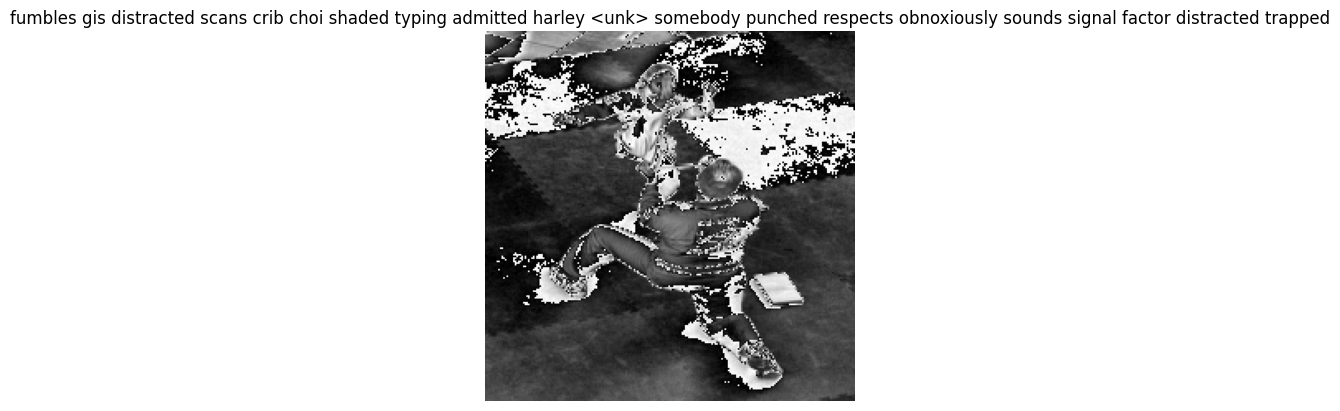

In [14]:
import matplotlib.pyplot as plt
from torchvision import transforms


def generate_caption(model, image, vocab, max_len=20):
    model.to(device)  # Ensure the model is on the device
    model.eval()
    with torch.no_grad():
        image = image.to(device)  # Move image to the device
        features = model.swin_model(image.unsqueeze(0))
        caption = [vocab['<start>']]
        for _ in range(max_len):
            caption_tensor = torch.tensor(caption).unsqueeze(0).to(device)  # Move tensor to the device
            outputs = model.caption_generator(features, caption_tensor)
            next_word_id = outputs.argmax(dim=-1)[:, -1].item()
            caption.append(next_word_id)
            if next_word_id == vocab['<end>']:
                break
        caption = [word for word in caption if word not in [vocab['<start>'], vocab['<end>'], vocab['<pad>']]]
        return ' '.join([list(vocab.keys())[list(vocab.values()).index(idx)] for idx in caption])

def display_image_with_caption(image, caption):
    transform = transforms.ToPILImage()
    image = transform(image.cpu())  # Convert image tensor to PIL image
    plt.imshow(image)
    plt.title(caption)
    plt.axis('off')
    plt.show()

# Example usage
image, _ = test_dataset[2]
caption = generate_caption(model, image, vocab)
print(f'Generated Caption: {caption}')
display_image_with_caption(image, caption)
